<a href="https://colab.research.google.com/github/albertodiazr/TFM_churn/blob/main/03_1_MVP_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo MVP con Deep Learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Using Activo and Baja for 0 and 1 (confusion matrix)   
class_names = ['Activo','Baja']

pd.options.display.max_columns = None

%matplotlib inline

In [4]:
data = pd.read_excel('/content/drive/MyDrive/TFM_Churn/data/portfolio_com_valencia.xlsx')
data['Cliente'] = data['Cliente'].astype('str')
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43


In [5]:
data['Born Date'].isnull().sum()

226

In [6]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43


In [7]:
data['Born Date'].isnull().sum()

0

In [8]:
# Edad en el momento del alta

data['Edad'] = ((data['Fecha Alta'] - data['Born Date']).dt.days)/365
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356


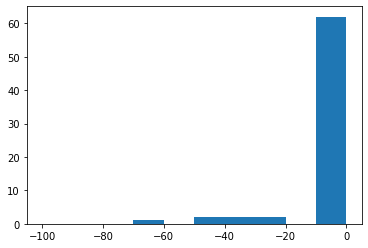

In [9]:
plt.hist(data['Edad'], range = (-100,0));

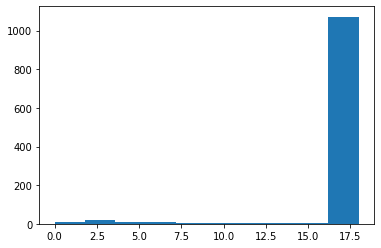

In [10]:
plt.hist(data['Edad'], range = (0,18));

In [11]:
edad_mean = data['Edad'].mean()
edad_mean

49.411166614701536

In [12]:
data['Edad'] = data['Edad'].apply(lambda x: edad_mean if x<18 else x)

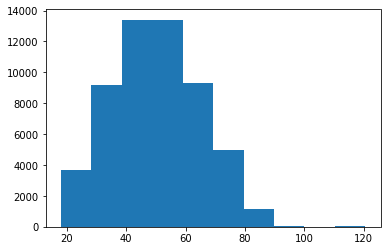

In [13]:
plt.hist(data['Edad']);

In [14]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30


In [15]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Rango_Edad,,,,,
+80,961,203,1164,0.825601,0.174399
18-30,2584,2258,4842,0.533664,0.466336
30-40,6163,3749,9912,0.621772,0.378228
40-50,10346,3941,14287,0.724155,0.275845
50-60,9324,2274,11598,0.803932,0.196068
60-70,7571,1276,8847,0.855770,0.144230
70-80,3988,589,4577,0.871313,0.128687
All,40937,14290,55227,0.741250,0.258750


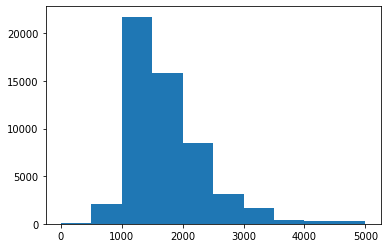

In [16]:
plt.hist(data['Ingresos'], range=(0, 5000));

In [17]:
data.loc[data['Ingresos'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Ingresos'] > 1000) & (data['Ingresos'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Ingresos'] > 1500) & (data['Ingresos'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Ingresos'] > 2000) & (data['Ingresos'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Ingresos'] > 3000, 'Income'] = "+3000"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000


In [18]:
tab1 = pd.crosstab(data["Income"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Income,,,,,
+3000,1687,448,2135,0.790164,0.209836
0-1000,6979,3147,10126,0.689216,0.310784
1000-1500,18436,6408,24844,0.742071,0.257929
1500-2000,9482,3084,12566,0.754576,0.245424
2000-3000,4353,1203,5556,0.783477,0.216523
All,40937,14290,55227,0.741250,0.258750


In [19]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Quejas_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,0.035714
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,0.000000
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,0.035714
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,0.035714
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,0.000000


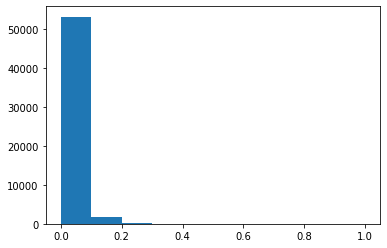

In [20]:
plt.hist(data['Quejas_sca']);

In [21]:
scaler = MinMaxScaler()
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Quejas_sca,Incidencias_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,0.035714,0.000000
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,0.000000,0.000000
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,0.035714,0.000000
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,0.035714,0.000000
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,0.000000,0.470588


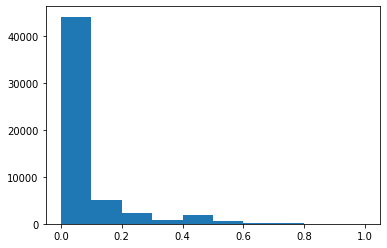

In [22]:
plt.hist(data['Incidencias_sca']);

In [23]:
scaler = MinMaxScaler()
data['Consumo_sca'] = scaler.fit_transform(data['Consumo Mes'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Quejas_sca,Incidencias_sca,Consumo_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,0.035714,0.000000,0.385207
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,0.000000,0.000000,0.133043
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,0.035714,0.000000,0.251823
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,0.035714,0.000000,0.090647
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,0.000000,0.470588,0.126815


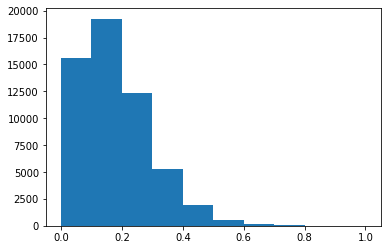

In [24]:
plt.hist(data['Consumo_sca']);

In [25]:
data_filtered = data[['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
                      'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales', 'Precio Total',
                      'Quejas_sca', 'Incidencias_sca', 'Consumo_sca', 'Estado']]
data_filtered.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Precio Total', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca', 'Estado'],
      dtype='object')

In [26]:
X = data_filtered.drop(['Estado'],axis=1)
y = data_filtered['Estado']

In [27]:
from sklearn.model_selection import train_test_split
X_train_prev, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [28]:
features_TE = ['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 'Precio Total',
               'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales']

In [29]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 6.7 MB/s 


In [30]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
X_train_prev.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
25918,Hombre,Casa,Propiedad Total,Jubilado,Casado,Alicante,España,60-70,0-1000,0 - 100 EUR,12,399,0.035714,0.000000,0.234751
5305,Hombre,Piso,Empresa,Autonomo,Casado,Alicante,España,40-50,1000-1500,0 - 100 EUR,14,399,0.000000,0.000000,0.059634
38504,Hombre,Casa,Propiedad Total,Trabajo Fijo,Casado,Alicante,Union Europea,40-50,1500-2000,0 - 100 EUR,14,399,0.000000,0.000000,0.299881
35496,Hombre,Piso,Propiedad Total,Jubilado,Viudo,Alicante,España,+80,1000-1500,100 - 200 EUR,12,499,0.000000,0.000000,0.061728
8046,Hombre,Piso,Propiedad Total,Autonomo,Casado,Valencia,España,60-70,1000-1500,100 - 200 EUR,14,499,0.000000,0.117647,0.081836


In [32]:
TE_encoder.fit(X_train_prev, y_train)
X_train = TE_encoder.transform(X_train_prev)
X_train.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
25918,0.2536,0.207625,0.229333,0.144286,0.219828,0.220812,0.254659,0.145050,0.311213,0.326792,0.282987,0.312914,0.035714,0.000000,0.234751
5305,0.2536,0.210947,0.272727,0.337908,0.219828,0.220812,0.254659,0.277612,0.257715,0.326792,0.234842,0.312914,0.000000,0.000000,0.059634
38504,0.2536,0.207625,0.229333,0.219986,0.219828,0.220812,0.250320,0.277612,0.244343,0.326792,0.234842,0.312914,0.000000,0.000000,0.299881
35496,0.2536,0.210947,0.229333,0.144286,0.183570,0.220812,0.254659,0.163866,0.257715,0.237826,0.282987,0.250299,0.000000,0.000000,0.061728
8046,0.2536,0.210947,0.229333,0.337908,0.219828,0.272935,0.254659,0.145050,0.257715,0.237826,0.234842,0.250299,0.000000,0.117647,0.081836


In [33]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
15591,0.253600,0.210947,0.229333,0.337908,0.370321,0.272935,0.254659,0.196224,0.244343,0.326792,0.282987,0.312914,0.000000,0.000000,0.107919
27726,0.278034,0.210947,0.229333,0.337908,0.370321,0.272935,0.254659,0.378727,0.257715,0.185057,0.234842,0.195478,0.000000,0.000000,0.021408
16792,0.253600,0.207625,0.229333,0.460733,0.219828,0.220812,0.254659,0.196224,0.257715,0.326792,0.234842,0.312914,0.000000,0.000000,0.210002
23233,0.253600,0.210947,0.229333,0.337908,0.219828,0.343207,0.254659,0.378727,0.257715,0.308267,0.234842,0.312914,0.035714,0.411765,0.042248
24836,0.253600,0.207625,0.229333,0.219986,0.219828,0.343207,0.254659,0.378727,0.244343,0.237826,0.234842,0.250299,0.000000,0.000000,0.280463


## Deep Learning

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, losses, metrics, optimizers

In [101]:
model = models.Sequential()

model.add(layers.Dense(100, input_dim=15, activation = 'tanh'))
model.add(layers.Dense(300, activation = 'tanh'))
model.add(layers.Dense(300, activation = 'tanh'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 100)               1600      
_________________________________________________________________
dense_29 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_30 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 301       
Total params: 122,501
Trainable params: 122,501
Non-trainable params: 0
_________________________________________________________________


In [102]:
sgd = optimizers.SGD(lr = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics=['accuracy'])
# model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics=[tf.keras.metrics.Recall(thresholds=0.5)])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [103]:
class_weight = {0: 1.,
                1: 3.}

In [104]:
h = model.fit(X_train, y_train, epochs = 100, batch_size = 4096, validation_split=.2, class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
9/9 [==============================] - 1s 70ms/step - loss: 1.0659 - accuracy: 0.6879 - val_loss: 0.6964 - val_accuracy: 0.4246
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 1.0610 - accuracy: 0.3559 - val_loss: 0.7058 - val_accuracy: 0.2758
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 1.0568 - accuracy: 0.2629 - val_loss: 0.7108 - val_accuracy: 0.2609
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 1.0550 - accuracy: 0.2545 - val_loss: 0.7143 - val_accuracy: 0.2604
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 1.0482 - accuracy: 0.2521 - val_loss: 0.7157 - val_accuracy: 0.2645
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 1.0532 - accuracy: 0.2605 - val_loss: 0.7148 - val_accuracy: 0.2652
Epoch 7/100
9/9 [==========

In [39]:
def plot_history(history, metric):

  d = history.history
  epochs = range(1, len(d[metric]) + 1)

  plt.plot(epochs, d[metric])

  if 'val_' + metric in d:
    plt.plot(epochs, d['val_' + metric])

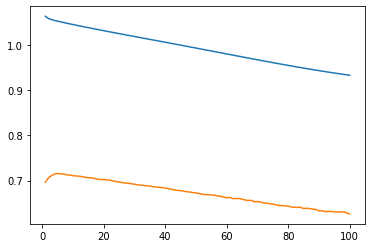

In [105]:
plot_history(h, 'loss')

In [106]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [107]:
# rounded = [int(round(x[0])) for x in y_pred]
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
              
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      8188
           1       0.45      0.69      0.54      2858

    accuracy                           0.70     11046
   macro avg       0.66      0.70      0.66     11046
weighted avg       0.76      0.70      0.72     11046



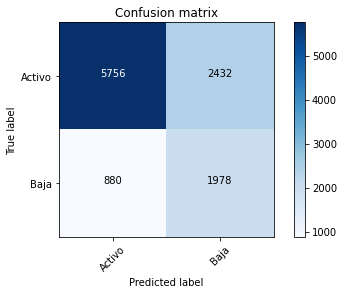

In [109]:
class_names = ['Activo','Baja']
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')